In [1]:
import emat

Open an existing database.

In [2]:
db = emat.SQLiteDB('gbnrtc_1.sqlitedb.gz')

Review what named `Scope` objects are stored in the database.

In [3]:
db.read_scope_names()

['GBNRTC']

In [4]:
scope = db.read_scope('GBNRTC')

Load `Boxes` from a database.  Since there is only one scope,
we could just call the method with no arguments and it will figure
out what we want, but in this demo we'll load a specific named scope.

In [5]:
boxes = db.read_boxes('GBNRTC')

Let's review the contents of the `Boxes` we have loaded.
`Boxes.plain_names` just gives us the names of the various
`Box` definitions.

In [6]:
boxes.plain_names()

[None,
 'High Population Growth',
 'Automated Vehicles',
 'Kensington Strategy Off',
 'Kensington Strategy On',
 'Kensington Off & Low Pop',
 'LRT Strategy Off',
 'LRT Strategy On']

`Boxes.fancy_names` adds some icons to show the hierarchy of the
`Box` definitions as well.

In [7]:
boxes.fancy_names()

['Boxes Universe',
 '▶ High Population Growth',
 '▷ ▶ Automated Vehicles',
 '▷ ▶ Kensington Strategy Off',
 '▷ ▶ Kensington Strategy On',
 '▶ Kensington Off & Low Pop',
 '▷ ▶ LRT Strategy Off',
 '▷ ▶ LRT Strategy On']

Any single box definition gives a set of thresholds that limit the exploratory space with the scope.

In [8]:
box_av = boxes.get('Automated Vehicles')
box_av

Box: Automated Vehicles
   ●       Freeway Capacity >= 1.25
   ●  Auto IVTT Sensitivity <= 0.9

A single box also knows about it's parent in the hierarchy.

In [9]:
box_av.parent_box_name

'High Population Growth'

We can see what's in that parent as well.  The filled bullets denote
scope dimensions that are actually restricted with a threshold.
The open bullets denote scope dimensions that are "of interest"
in our analysis but are not restricted.

In [10]:
boxes.get('High Population Growth')

Box: High Population Growth
   ●             Land Use - CBD Focus >= 1
   ◌               Peak Transit Share
   ◌           AM Trip Length (miles)
   ◌              Total LRT Boardings
   ◌    Corridor Kensington Daily VMT
   ◌  Downtown to Airport Travel Time
   ◌          Total Transit Boardings
   ◌           AM Trip Time (minutes)
   ◌                  Region-wide VMT

The 'High Population Growth' box has no parent to inherit anything from; it's the top of a chain.

In [11]:
boxes.get('High Population Growth').parent_box_name is None

True

We can load the entire chain of boxes together using `Boxes.get_chain`.

In [12]:
chain = boxes.get_chain('Automated Vehicles')
chain

ChainedBox: Automated Vehicles
   ●             Land Use - CBD Focus >= 1
   ●                 Freeway Capacity >= 1.25
   ●            Auto IVTT Sensitivity <= 0.9
   ◌               Peak Transit Share
   ◌           AM Trip Length (miles)
   ◌              Total LRT Boardings
   ◌    Corridor Kensington Daily VMT
   ◌  Downtown to Airport Travel Time
   ◌          Total Transit Boardings
   ◌           AM Trip Time (minutes)
   ◌                  Region-wide VMT

Let's load some data from the database.  We'll use 'lhs_2', which has
a large latin hypercube sample of metamodel results.

In [13]:
import pandas

def load_from_database(
        db,
        scope,
        design_name,
        feature_names,
):
    X = db.read_experiment_all(scope.name, design_name)
    # Put feature names in order
    m_names = [i for i in feature_names if i in scope.get_measure_names()]
    x_names = [i for i in feature_names if i in scope.get_uncertainty_names()]
    l_names = [i for i in feature_names if i in scope.get_lever_names()]
    return X.loc[:, x_names+l_names+m_names]



df = load_from_database(
    db,
    scope,
    feature_names=chain.relevant_features|chain.demanded_features,
    design_name='lhs_2',
)

The `inside` method of `Box` and `ChainedBox` (added in TMIP-EMAT v0.1.4) is shown below. 
It is a quick and easy way to filter all the experiments in a DataFrame that are inside (or outside) the box.

In [14]:
def inside(box, df):
    within = pandas.Series(True, index=df.index)
    for label, bounds in box.thresholds.items():
        if bounds.lowerbound is not None:
            within &= (df[label] >= bounds.lowerbound)
        if bounds.upperbound is not None:
            within &= (df[label] <= bounds.upperbound)
    return within
    
# Monkey-patch for prior versions
emat.Box.inside = inside
emat.ChainedBox.inside = inside

In [15]:
df['in_box'] = in_box = chain.inside(df)

Then it's off to the races with statistical and visual analysis of the results in Python.

In [16]:
from matplotlib import pyplot as plt

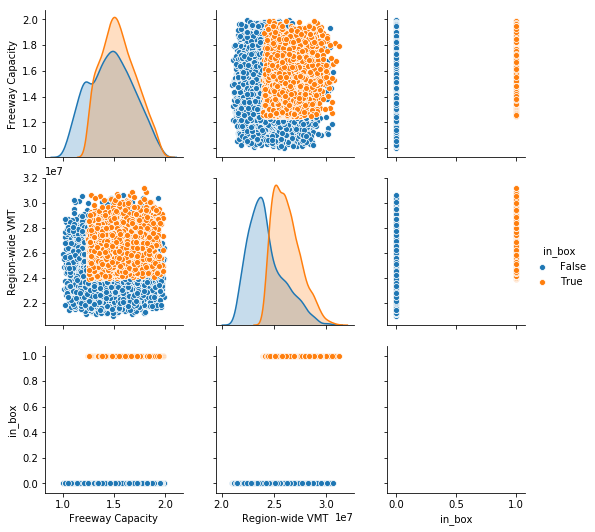

In [18]:
import seaborn as sns
sns.pairplot(df[['Freeway Capacity', 'Region-wide VMT', 'in_box']], hue="in_box")